# Emulator Performance (Figure 3)

This script generates Figure 3. Emulator performance comparing the predicted mixing state indices with the reference indices.

In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import pickle
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import gc
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Calculate squared_error
def squared_error(y_ori,y_pred):
    return np.sum((y_pred - y_ori) * (y_pred - y_ori))

# Calculate coefficient of determination
def coefficient_of_determination(y_ori,y_pred):
    """
    ref: https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    y_mean_pred = np.full(np.asarray(y_ori).shape, np.mean(y_ori)) 
    SSres = squared_error(y_ori, y_pred)
    SStot = squared_error(y_ori, y_mean_pred)
    return 1 - (SSres/SStot)

# Calculate index of agreement
def index_agreement(ori,pred):
    """
    ref: https://www.rforge.net/doc/packages/hydroGOF/d.html
    index of agreement
    input:
        pred: simulated
        ori: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((ori-pred)**2))/(np.sum(
        (np.abs(pred-np.mean(ori))+np.abs(ori-np.mean(ori)))**2))
    return ia

In [2]:
vari = ["DMS_SRF","H2O2_SRF","H2SO4_SRF","O3_SRF","SO2_SRF","SOAG_SRF",
        'Mass_so4','Mass_bc','Mass_ncl','Mass_dst','Mass_pom','Mass_soa',
        "T", "RELHUM", "SZA"]
chi_ls = ['chi_abd','chi_opt1','chi_opt2','chi_hyg']
vari_ms = vari+chi_ls

case_ensemble = {}
case_ls = []
for i in range(1,5):
    case_ensemble["case_"+str(i)] = pd.read_csv("../data/test_"+str(i)+".csv")
    case_ls.append(pd.read_csv("../data/test_"+str(i)+".csv"))
case_describe = {}
case_describe["case_1"] = "sea salt and dust" 
case_describe["case_2"] = "dust"
case_describe["case_3"] = "sea salt"
case_describe["case_4"] = "none"

df_test_ori = pd.concat(case_ls)
#df_test.describe()


case_ensemble = {}
case_ls = []
for i in range(1,5):
    case_ensemble["case_"+str(i)] = pd.read_csv("../data/train_"+str(i)+".csv")
    case_ls.append(pd.read_csv("../data/train_"+str(i)+".csv"))
case_describe = {}
case_describe["case_1"] = "sea salt and dust" 
case_describe["case_2"] = "dust"
case_describe["case_3"] = "sea salt"
case_describe["case_4"] = "none"

df_train_ori = pd.concat(case_ls)
#df_train.describe()

In [3]:
def predict_chi_ls(df, vari, chi):
    df_copy = df.copy().dropna()
    #for chi in chi_ls:
    print(chi)
    XGBreg_load=pickle.load(open("./xgb_model/"+chi+".dat","rb"))
    X=df_copy[vari]
    Y_ref=df_copy[chi]
    df_predictions = XGBreg_load.predict(X)
    """
    plt.figure(figsize=(10,10))
    plt.scatter(df_predictions*100,Y_ref*100,s = 6,color="purple",alpha=0.5)
    plt.plot([0,100],[0,100],color="red",alpha=0.6)
    #plt.title("Predicted om vs Actual om")
    plt.ylabel("Reference, %",fontsize=20)
    plt.xlabel("Prediction, %",fontsize=20)
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    """
    #https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
    X = np.asarray(Y_ref)
    y = np.asarray(df_predictions)
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    #print(est2.summary())
    print('The P-value is:',
          "{0:.3f}".format(est2.f_pvalue))
    print('The cc is:',
          "{0:.3f}".format(np.corrcoef(np.asarray(Y_ref),np.asarray(df_predictions))[0][1]))
    print('The coefficient of determination is:',
          "{0:.3f}".format(coefficient_of_determination(Y_ref,df_predictions)))
    print('The coefficient of determination (Using sklearn) is:', 
          "{0:.3f}".format(metrics.r2_score(Y_ref, df_predictions)))
    print('The index of agreement is:',
          "{0:.3f}".format(index_agreement(Y_ref,df_predictions)))
    print('The root mean squared error is:', 
          "{0:.3f}".format(np.sqrt(mean_squared_error(Y_ref, df_predictions))))
    print('The mean absolute error is:', 
          "{0:.3f}".format(metrics.mean_absolute_error(Y_ref, df_predictions)))
    print('The median absolute error is:', 
          "{0:.3f}".format(metrics.median_absolute_error(Y_ref, df_predictions)))
    xgb.plot_importance(XGBreg_load)
    plt.show()
    print("####################################")
    print("\n")
    
    return Y_ref, df_predictions

chi_abd
The P-value is: 0.000
The cc is: 0.894
The coefficient of determination is: 0.796
The coefficient of determination (Using sklearn) is: 0.796
The index of agreement is: 0.943
The root mean squared error is: 0.062
The mean absolute error is: 0.047
The median absolute error is: 0.036


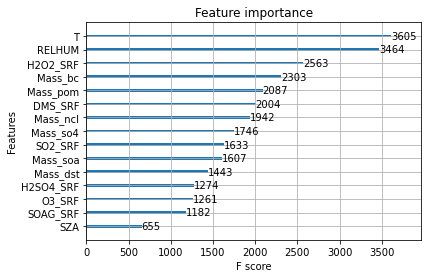

####################################


chi_opt1
The P-value is: 0.000
The cc is: 0.884
The coefficient of determination is: 0.778
The coefficient of determination (Using sklearn) is: 0.778
The index of agreement is: 0.935
The root mean squared error is: 0.069
The mean absolute error is: 0.053
The median absolute error is: 0.041


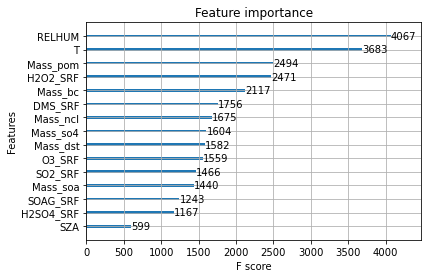

####################################


chi_hyg
The P-value is: 0.000
The cc is: 0.836
The coefficient of determination is: 0.696
The coefficient of determination (Using sklearn) is: 0.696
The index of agreement is: 0.907
The root mean squared error is: 0.094
The mean absolute error is: 0.074
The median absolute error is: 0.061


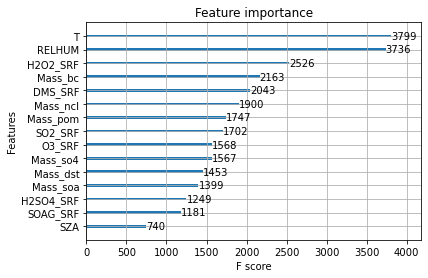

####################################




In [4]:
abd_ref, abd_pred = predict_chi_ls(df_test_ori, vari, "chi_abd")
opt_ref, opt_pred = predict_chi_ls(df_test_ori, vari, "chi_opt1")
hyg_ref, hyg_pred = predict_chi_ls(df_test_ori, vari, "chi_hyg")

# Plot

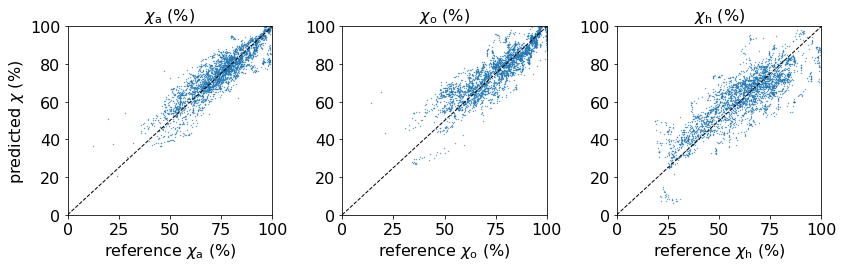

In [22]:
rc={'axes.labelsize': 16,
    'font.size': 16, 'legend.fontsize': 16, 
    'axes.titlesize': 16,
    'xtick.labelsize': 16.0,
    'ytick.labelsize': 16.0}
plt.rcParams.update(**rc)

f, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(12,4))
ax1.scatter(abd_ref*100,abd_pred*100,s=0.1)
ax1.plot([0,100], [0,100], 'k--', linewidth = 1)
ax1.set_title(r"$\chi_{\rm a}$ (%)")
ax1.set_xlim(0,100)
ax1.set_xlabel(r"reference $\chi_{\rm a}$ (%)")
ax1.set_ylim(0,100)
ax1.set_ylabel(r'predicted $\chi$ (%)')

ax2.scatter(opt_ref*100,opt_pred*100,s=0.1)
ax2.plot([0,100], [0,100], 'k--', linewidth = 1)
ax2.set_title(r"$\chi_{\rm o}$ (%)")
ax2.set_xlim(0,100)
ax2.set_xlabel(r"reference $\chi_{\rm o}$ (%)")
ax2.set_ylim(0,100)

ax3.scatter(hyg_ref*100,hyg_pred*100,s=0.1)
ax3.plot([0,100], [0,100], 'k--', linewidth = 1)
ax3.set_title(r"$\chi_{\rm h}$ (%)")
ax3.set_xlim(0,100)
ax3.set_xlabel(r"reference $\chi_{\rm h}$ (%)")
ax3.set_ylim(0,100)

plt.tight_layout()
plt.savefig("../figures/emulator_performance.pdf")
plt.show()